# Computer Vision Training YM

## 1: Introduction to Convnets with pytorch 
In this section will will build a simple convolutional model and train it to classify images from the CIFAR-10 dataset. The CIFAR-10 dataset is one of the first large scale image datasets, but the images are very small (32x32). All convolutional models will do well on this if they have enough layers.

#### Download the data using the torchvision library
Pytorch has some build in libraries to download certain datasets, the CIFAR-10 dataset is one of them. 

In [2]:
# convnet classification task on 
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    # you can add other transformations in this list if you want.
    transforms.ToTensor()
])

cifar10_train_dataset = torchvision.datasets.CIFAR10("./cifar10", download=True, transform=transform, train=True)
cifar10_test_dataset = torchvision.datasets.CIFAR10("./cifar10", download=True, transform=transform, train=True)

Files already downloaded and verified
Files already downloaded and verified


#### Make dataloaders from the datasets
Wrap the dataset classes in a pytorch dataloader class. This will allow us to feed the data to the model in a easy and controllable way.

target label    : automobile
shape of tensors: batch=torch.Size([256, 3, 32, 32]), target=torch.Size([256])


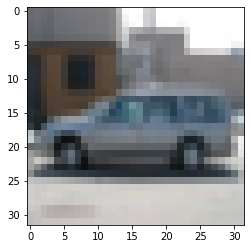

In [23]:
# adjust batch size to fit gpu space AND for finetuning the training process, you'll have to do this for all different exercises.
# batch size is not an insignificant factor in the training of convnets (or any neural networks for that matter)
batch_size = 32

train_loader = torch.utils.data.DataLoader(cifar10_train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=5)

test_loader = torch.utils.data.DataLoader(cifar10_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=5)

# the dataset class should contain the mapping of label to label_idx
label_to_classname = {v: k for k, v in cifar10_test_dataset.class_to_idx.items()}

# show single sample
for batch, target in test_loader:
    sample = batch[0].permute(1, 2, 0)
    t_label = target[0].item()
    print(f"target label    : {label_to_classname[t_label]}")
    print(f"shape of tensors: batch={batch.shape}, target={target.shape}")
    plt.imshow(sample.numpy())
    break

#### Build your convolutional model
Use 2d Convolutional layers and ReLU layers to construct a simple neural network. You will also need a linear layer at the end and perhaps some dropout layers.

In [9]:
class VerySimpleNet(nn.Module):
    def __init__(self, n_classes):
        super(VerySimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(256, 512, 3, 1)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.fc = nn.Linear(247808, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

#### Training and testing the model
We'll now define basic training and testing routines. In pytorch you'll have to specify which optimizer, loss and scheduler (if you want to use one) you want to use and put the statements in the right spots.

In [11]:
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval=5, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

device = "cuda:0"
lr = 0.001
gamma = 0.7
epochs = 5
model = VerySimpleNet(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, log_interval=100)
    test(model, device, criterion, test_loader)
    scheduler.step()


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302552
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.908845
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.818860
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.972895
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.790232
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.486967
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.971574
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.642589
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.442186
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.381911
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.519168
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.461612
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.327360
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.174348
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.374987
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.110867

Test set: Average loss: 0.0385, Accuracy: 28129/50000 (56.26%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.065154
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.283102
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.555317
Tr

#### Inspecting the results
Lets look at some classification examples from the test set, how does your model perform?

target label: airplane, predicted label: bird


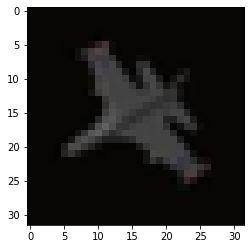

In [17]:
for batch, target in test_loader:
    sample = batch[0].permute(1, 2, 0)
    output = model(batch.to(device))
    p_label = torch.argmax(output[0]).item()
    t_label = target[0].item()
    print(f"target label: {label_to_classname[t_label]}, predicted label: {label_to_classname[p_label]}")
    plt.imshow(sample.numpy())
    
    break

## Understanding Convnets - Architecture, Backbones & Layers
Backbones are large (often pretrained) neural networks that serve as a way to extract features that are useful for almost all types of problems.
The general idea of a backbone is to have a model that is very good at identifying high level features in an image. 
The easiest way to understand this is to think of images as collections of shapes. A face is just a collection of circles (such as the eyes) and curvy lines.
This means that if we already have a model that can detect all these components the step to the full combination of those components (such as a face) is a lot easier!
In practice most pretrained backbones will already have concepts such as faces embedded into the layers. Additionally, lines and circles are actually pretty basic features and a large pretrained backbone will contain much more complex concepts.

### Revisiting CIFAR-10 
Now we know about backbones, let's use one on the CIFAR-10 dataset. For this we'll need to download a pretrained model and adjust the number of classes. We'll pick the resnext50 backbone model, a variant of the resnet style architecture (see, https://pytorch.org/hub/pytorch_vision_resnext/).

In [18]:
resnext50 = models.resnext50_32x4d(pretrained=True)

# you can always print a model to see the full structure or even the partial structure if you select it.
print(resnext50.layer1)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2)

#### Changing a backbone
We now want to change the backbone so it fits our 10 class classification problem. There are a few ways to do this and here we will look at both of the methods.

1. The first (and easiest) way is to change the model is to just swap out the last layer. In this case the original model was already a classification model and we are just changing the number of output classes in the last layer to fit our problem. In this case this is also the most 'correct' way of doing it.
2. The second way to adjust the model is to wrap it in a new model class. This method is useful in more complicated scenarios where you want to change more than just the number of outputs. For example if we wanted to use the backbone as the basis for a segmentation model. Now before you ask, yes wrapping the backbone like this preserves the last layer that would be replaced in the other example, luckily this does not effect performance (only memory usage).

In [25]:
resnext50 = models.resnext50_32x4d(pretrained=True)
num_classes = 10

# change the last layer of the model, (run the training cell further below to see if it worked):
resnext50.fc = nn.Linear(2048, num_classes)

print(resnext50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [26]:
# now let's wrap our model in a pytorch module instead, this is syntactically the same as adding a layer to a regular network.

class WrappedResnext(nn.Module):
    def __init__(self, n_classes, backbone):
        super(WrappedResnext, self).__init__()
        self.backbone = backbone
        self.fc2 = nn.Linear(1000, n_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc2(x)
        return x

resnext50 = models.resnext50_32x4d(pretrained=True)
model = WrappedResnext(10, resnext50)
print(model)

WrappedResnext(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

#### Test your adjusted model by running the cell below
Now that we've adjusted our model for our problem we can try it out. 

In [27]:
device = "cuda:0"
gamma = 0.7
epochs = 10
learning_rate = 0.001

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, log_interval=100)
    test(model, device, criterion, test_loader)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.920835
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.013369

Test set: Average loss: 0.1721, Accuracy: 25017/50000 (50.03%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.076702
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.825145

Test set: Average loss: 0.0020, Accuracy: 41463/50000 (82.93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.544019
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.481807

Test set: Average loss: 0.0013, Accuracy: 44790/50000 (89.58%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.392664
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.290239

Test set: Average loss: 0.0010, Accuracy: 46094/50000 (92.19%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.247350
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.148309

Test set: Average loss: 0.0004, Accuracy: 48350/50000 (96.70%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.130290
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.144154

Test set: Average loss: 0.0003, Accuracy: 49262/50000 (98.52%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.07

#### Inspecting the results
And? does the model perform better? can you even tell without training for a (very) long time?
try looking at some examples.

target label: bird, predicted label: bird


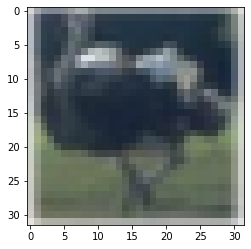

In [42]:
# If you want to see some samples
for batch, target in test_loader:
    sample = batch[0].permute(1, 2, 0)
    output = model(batch.to(device))
    p_label = torch.argmax(output[0]).item()
    t_label = target[0].item()
    print(f"target label: {label_to_classname[t_label]}, predicted label: {label_to_classname[p_label]}")
    plt.imshow(sample.numpy())
    
    break

# Before you start this section!
We will be using another fairly large dataset in this section so turn on the download by running the imports and the the *Testing the model* section 

# 2: Understanding Convnets - Model architecture
In this section we'll look at Unet, a classic (compared to more recent models) deep learning segmentation model that introduced the concept of encoder-decoder architecture. It is also fairly easy to understand. It consists of two parts, the encoder and the decoder. The Encoder has the same job as the backbone has in the previous section: Its purpose is to extract features (you can thing of the as classifications or objects) from the image, that will then be used in the second half of the model (the decoder) to make the segmentation, (place those objects in the right place with the right boundries). In this sense, the Decoder does the same thing as the single layer of linear nodes in the backbone example. It uses the features supplied by the encoder to make a classification, just for all pixels in the image instead of the entire image. 

So thats the general idea, but what are some of the other interesting parts of the model? 
1. As we can see in the image below, the shape of the layers gets deeper in filters but smaller in width/height.
This is done to allow the model to learn larger more complex concepts. As the size of the convolutional filters stays the same throughout the model (generally kernel size is always 3x3), a larger object like a car would never fit in those 3 pixels. By downsizing the output after each layer, a full object CAN be represented in that 3x3 grid of pictures. 
This is because filters specialize, a certain filter in the 4th layer of the model might only respond to a specific pattern that was found in the previous layer. That pattern is again already an abstraction upon the previous input etc. etc. until you reach the first layer where only lines and squiggles are detected.

2. What are those grey lines jumping from the enconder part to the decoder part? As you might have suspected this is just the output of that layer being saved and copied to be concatenated to the decoder at the mirrored layer later. This is done because a lot of spatial detail is lost in the process of downsampling. By adding the higher resolution data from the downsampling process this effect is somewhat mitigated as the network is able to use this data to make more precise object boundaries. 

![alt text](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png "Logo Title Text 1")


#### Building the segmentation model
I've defined some functions to get you started, try to complete the model based on the architecture shown above. you can use a linear layer at the end but you don't have to.

In [1]:
# imports so you don't have to scroll up when you get an OOM error
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## From classification model to segmentation model

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()  
        # encoder
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)    

        # up
        self.maxpool = nn.MaxPool2d(2)
        
        # down
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        x = self.dconv_down4(x)

        x = self.upsample(x)      
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

#### Testing the model 
Lets try out our new model on another pytorch/torchvision dataset. We'll use the SBD dataset, another dataset that can be downloaded using the torchvision dataset library.
This dataset supplies full segmentations instead of just classes. Its a little trickier to use so I've completed this section for you, feel free to look around though.

In [10]:
from PIL import Image

# custom compose object to transform the pil images to tensors in the right format
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
            if type(t) != transforms.Normalize:
                target = t(target)
            
        return image, target

transform = []
transform.append(transforms.Resize((568, 568), interpolation=Image.NEAREST))
transform.append(transforms.ToTensor())
transform.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]))
transform = Compose(transform)

label_to_classname = {
    0: "background",
    1: "aeroplane",
    2: "bicycle",
    3: "bird",
    4: "boat",
    5: "bottle",
    6: "bus",
    7: "car",
    8: "cat",
    9: "chair",
    10: "cow",
    11: "diningtable",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "pottedplant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tvmonitor"
}

# this dataset is 1.4 Gigabyte so be patient. 
sbd_dataset = torchvision.datasets.SBDataset(root="./sbd", download=False, mode="segmentation", image_set='train', transforms=transform)

# pick the right batch_size, generally you would want to use at least 16 for any convnet training, 
# but often this will be impossible due to the size on smaller gpus, we're really only trying stuff out so you can use a smaller size if needed here
batch_size = 4 

train_loader = torch.utils.data.DataLoader(sbd_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=5)

#### Inspecting the data
Run this a few times to look at some examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes: ['background', 'car']


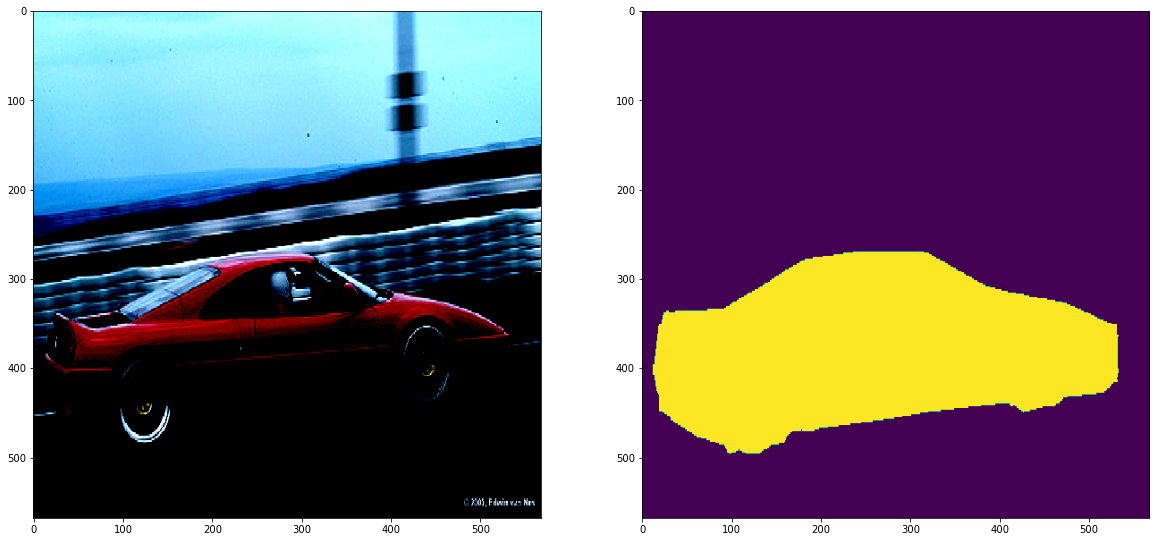

In [32]:
for image_batch, target_batch in train_loader:
    image = image_batch[0]
    target = target_batch[0]
    
    image_cl = image.permute(1, 2, 0)
    target_cl = target.permute(1, 2, 0)
    
    fig, axs = plt.subplots(1, 2, figsize=(20,10))
    
    # We are plotting normalized images here, you could turn denormalize them with the values in the transform operation, but for the purpose of seeing
    #the content of the image this is just fine
    axs[0].imshow(image_cl.numpy())
    
    # naive approach to muticlass plotting, classes are assigned different colors due to the values being different, but is not consistent between images
    axs[1].imshow(target_cl.numpy())
    print(f"classes: {[label_to_classname[c] for c in np.unique(target_cl.numpy()*255)]}")
    
    break

### Training the model
Training the segmentation model is basically the same as for any neural network. Just plug in the data and let the optimizer do the work.

In [33]:
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval=5, dry_run=False, overfitrun=False):
    model.train()
    losses = []
    n_iters = 0
    overfitdata = None
    overfittarget = None
    for batch_idx, (data, target) in enumerate(train_loader):
        if overfitrun:
            if batch_idx == 0:
                overfitdata = data 
                overfittarget = target
            else:
                data = overfitdata
                target = overfittarget
            
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        
        target = target.reshape(batch_size, 568, 568) * 255
        target = target.long()
        loss = criterion(output, target)
        losses.append(loss.item())
        n_iters += 1
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t average Loss (last 500): {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses[-500:])))
            if dry_run:
                break

# parameters
device = "cuda:0"
epochs = 10
learning_rate = 0.001
gamma = 0.7

# make the model
segmentation_model = UNet(sbd_dataset.num_classes + 1)  # all classes plus background class, the amount of classes can be confusing so pay close attention
segmentation_model = segmentation_model.to(device)

# define optimizer, loss function and scheduler
optimizer = optim.Adam(segmentation_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train(segmentation_model, device, train_loader, optimizer, criterion, epoch, log_interval=10)
    test(segmentation_model, device, criterion, train_loader)
    scheduler.step()

Train Epoch: 1 [0/8498 (0%)]	 average Loss (last 500): 3.009343
Train Epoch: 1 [40/8498 (0%)]	 average Loss (last 500): 3.037241
Train Epoch: 1 [80/8498 (1%)]	 average Loss (last 500): 2.625687
Train Epoch: 1 [120/8498 (1%)]	 average Loss (last 500): 2.345681
Train Epoch: 1 [160/8498 (2%)]	 average Loss (last 500): 2.260950
Train Epoch: 1 [200/8498 (2%)]	 average Loss (last 500): 2.125294
Train Epoch: 1 [240/8498 (3%)]	 average Loss (last 500): 2.003524
Train Epoch: 1 [280/8498 (3%)]	 average Loss (last 500): 1.900719
Train Epoch: 1 [320/8498 (4%)]	 average Loss (last 500): 1.858851
Train Epoch: 1 [360/8498 (4%)]	 average Loss (last 500): 1.826856
Train Epoch: 1 [400/8498 (5%)]	 average Loss (last 500): 1.800731
Train Epoch: 1 [440/8498 (5%)]	 average Loss (last 500): 1.742758
Train Epoch: 1 [480/8498 (6%)]	 average Loss (last 500): 1.723843
Train Epoch: 1 [520/8498 (6%)]	 average Loss (last 500): 1.711132
Train Epoch: 1 [560/8498 (7%)]	 average Loss (last 500): 1.679466
Train Epoch: 1

KeyboardInterrupt: 

#### You can save the model if you want or load one I pretrained

In [37]:
# save model 
# torch.save(segmentation_model.state_dict(), "segmentation_model.pt")

# load model
segmentation_model = UNet(sbd_dataset.num_classes + 1)
segmentation_model.load_state_dict(torch.load("segmentation_model.pt"))
segmentation_model.eval()
segmentation_model = segmentation_model.to(device)
print("done!")

done!


In [ ]:
torch.cuda.clear_cache()

In [ ]:
import gc
# tensors = []
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size())
            if obj.size() == torch.Size([4, 21, 568, 568]):
                del obj
            if obj.size() == torch.Size([4, 3, 568, 568]):
                del obj
            if obj.size() == torch.Size([4, 1, 568, 568]):
                del obj
    except:
        pass

#### Inspect the results
You can see the results of your training here. keep in mind however that it takes a long time to train a large model like this. You won't get good looking results unless you leave it running for a while. Try the pretrained backbone (look in the answers to find my implementation that fits it) for a working(-ish) example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.63127893
1.1428342
classes: ['background', 'aeroplane']


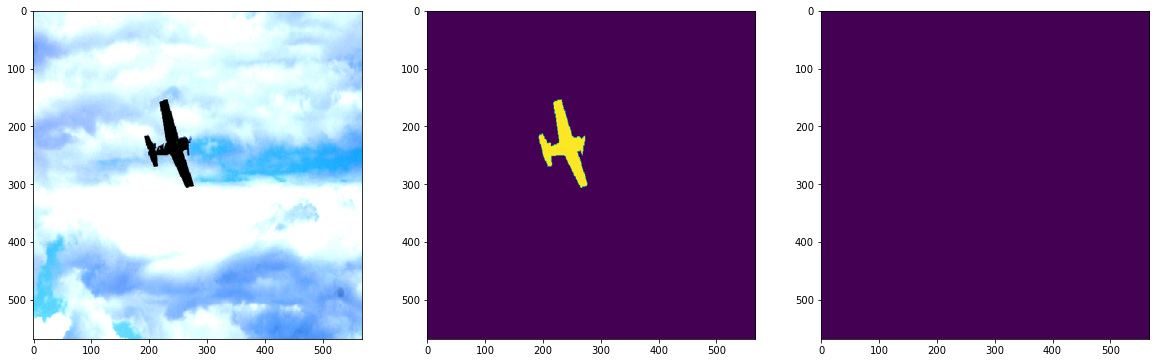

In [46]:
for image_batch, target_batch in train_loader:

    image = image_batch[0]
    target = target_batch[0]
    
    image_cl = image.permute(1, 2, 0)
    target_cl = target.permute(1, 2, 0)
    output = segmentation_model(image_batch.to(device)).cpu()
    
    print(np.mean(output.detach().numpy()))
    print(np.std(output.detach().numpy()))
    
    pred = torch.argmax(output[0], dim=0)
    
    fig, axs = plt.subplots(1, 3, figsize=(20,10))
    axs[0].imshow(image_cl.numpy())
    
    # naive approach to muticlass plotting, classes are assigned different colors due to the values being different, but is not consistent between images
    axs[1].imshow(target_cl.numpy())
    axs[2].imshow(pred.numpy())
    del image_batch
    del target_batch
    del output
    print(f"classes: {[label_to_classname[c] for c in np.unique(target_cl.numpy()*255)]}")
    
    break

# 3: Understanding Convnets - Filter Visualization 

An interesting area of research within convolutional neural networks is the interpretability. As you will likely know, neural networks are mostly black box solutions. It is hard to get an idea of why the network performs the way it does. There are several ways in which more insight can be gained from the model, but most of them focus on various ways of tracking the activation of the model on a certain image. Doing this for a large amount of images gives insight into what parts of the model respond to specific stimuly. This process is somewhat similar to how human or animal brains can be studied as well, if you are shown multiple similar pictures, most likely the same area of the brain will be used. 

Using neural networks however, we can do more than just track the activation throught the network. Neural networks, although they are large black boxes, are deterministic. This means that we always get the same output for the same image, but more interesting, this means we can make small adjustments to the input image and by doing so map the internal logic of the network! 

In this example we will apply a process called deep-dreaming (https://en.wikipedia.org/wiki/DeepDream) to see inside a neural network. More specifically we will change the optimization goal to visualize the convolutional filters. We will do so by inputting random noise and adjusting that noise to get a higher activation of a specific filter/layer. Adjusting values to get a higher activation? does that sound familiar? Well it should because this method uses the same backpropagation algorithm as regular training just with a different target!

## Preparing our model
For this task we will use a pretrained model. This is because a pretrained model will already have well trained filters that look for very specific patterns. If we were to use a untrained model we might not get good visualizations at all!

In [4]:
# imports
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import requests
import numpy as np
import torchvision.models as models
from io import BytesIO
from PIL import Image

In [5]:
# lets use the same resnext model as before
resnext50 = models.resnext50_32x4d(pretrained=True)

# set in eval mode to avoid adjusting the weights
resnext50.eval()
print("done")

done


In [6]:
# have a look at the layers & modules in the model 
# list(resnext50.modules())
resnext50.layer2[1].conv1

Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

#### Retrieving intermediate results
To do the optimization we need the output of a specific layer/module in the model. We can do this in pytorch by making use of a Hook. A hook will be attached to a specific location in the model and will save automatically save what we want when the models forward function is called. 

In [3]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        
    def close(self):
        self.hook.remove()

#### Getting gradients for optimization
Instead of optimizing using the loss gained by comparing the output to the target label, our loss will just be the activation of the layer that we set as target. Additionally we will be trying to get the loss as high as possible instead of low like in a regular training setup, this is called gradient ascent. 

In [12]:
#Function to make gradients calculations from the output channels of the target layer  
def get_gradients(model_input, model, layer, filter_idx):     
    model_input = model_input.unsqueeze(0).cuda() # some reshaping
    
    # we want to get gradients from the forward pass
    model_input.requires_grad = True
    
    # discard any previous gradients
    model.zero_grad()
    
    # apply the hook we made earlier to the target layer
    hook = Hook(layer)
    
    # do the forward pass, we won't actually use the final output
    model_output = model(model_input)
    
    # get the loss by retrieving the output saved by the hook.
    # we will take the norm of the output because we want extreme values in both directions, positive AND negative
    if filter_idx == -1:
        # loss of the entire output
        loss = hook.output[0].norm()
    else:
        # loss of a specific filter, the amount of filters is dependend on the layer you choose, 
        # early layers likely won't have quite as many as deeper layers
        loss = hook.output[0][filter_idx].norm()
    
    # use the loss to calculate the gradients
    loss.backward()
    
    # return the gradients we just calculated (and reshape data)
    return model_input.grad.data.squeeze()

#### Gradient Ascent
Now that we have a way to get specific outputs from inside the model and a way to calculate gradients for our optimization target, we can write the full deep dream function.
In this function we will prepare the image, perform the gradient ascent and return the final output.

In [10]:
# denormalization image transform, used to give the image the right colors again.
denorm = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                             transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                            ])

def dream(image, model, layer, iterations, lr, filter_idx):
    """Deep dream an image using given model and parameters."""
    
    # convert image to tensor
    image_tensor = transforms.ToTensor()(image)
    
    # remove additional channels (pngs will have a 4th transparancy channel)
    image_tensor = image_tensor[:3,:,:]
    
    # normalize the image
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
    
    # deep dream the iamge
    for i in range(iterations):
        # get gradients 
        gradients = get_gradients(image_tensor, model, layer, filter_idx)
        
        # add gradients to image to morph the image in a direction that causes a higher activation
        image_tensor.data = image_tensor.data + lr * gradients.data
        
    # get the final image from gpu
    img_out = image_tensor.detach().cpu()
    
    # denormalize
    img_out = denorm(img_out)
    
    # do some reshaping, conversion
    img_out_np = img_out.numpy().transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
    return img_out_pil

#### Deep Dreaming 
Now that we have all our functions, let's try them out on a bunch of images!

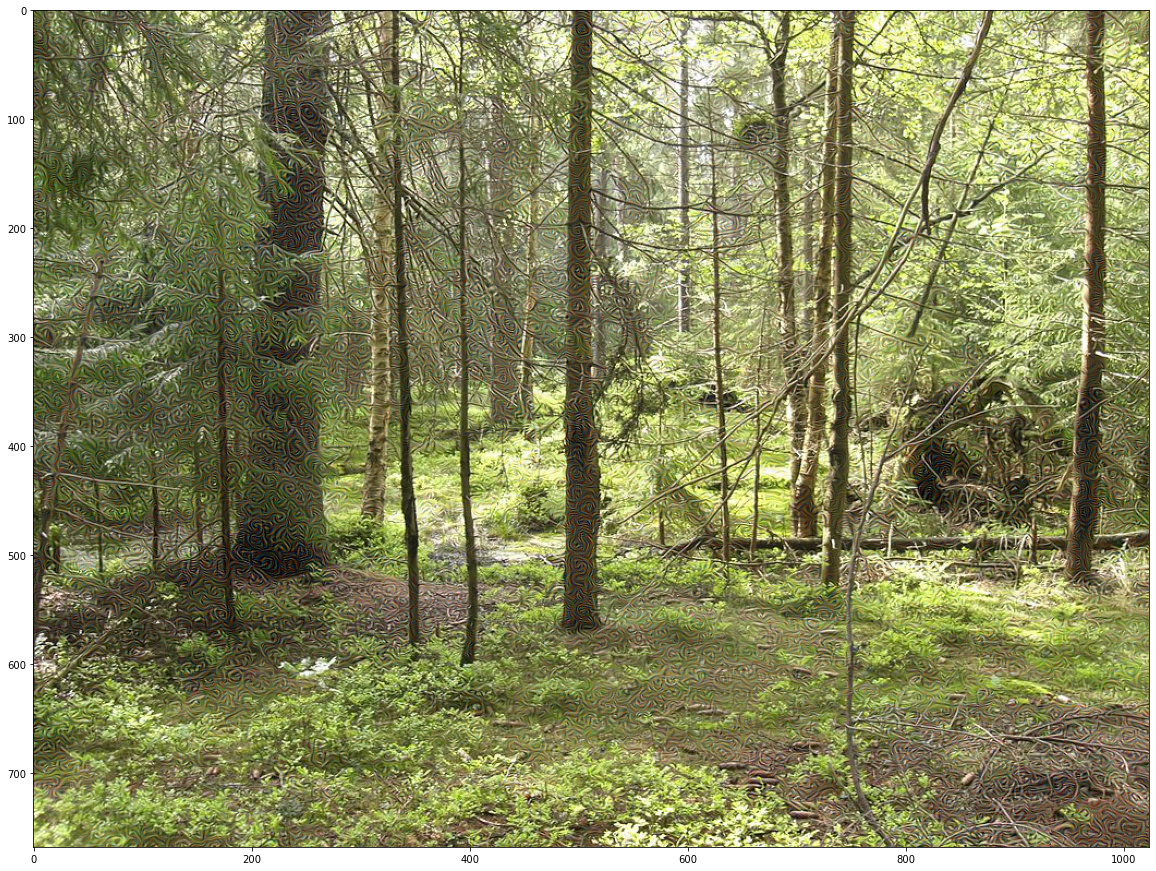

In [13]:
device = "cuda:0"

# Get an input image, I've used weblinks here but you can upload your own as well, you could even try using random noise!
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Kladsk%C3%A1_forrest.jpg/1024px-Kladsk%C3%A1_forrest.jpg'
# url = 'https://www.marineterrein.nl/wp-content/uploads/2019/02/IMG_8815-830x466.jpg'
# url = 'https://youngmavericks.com/img/contact_location.png'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

# might want to resize if they're very large, it would take a while to do the whole deep dream
orig_size = np.array(img.size)
# new_size = np.array(img.size)*0.5

# make sure its on the gpu
resnext50 = resnext50.to(device)

# pick a target layer
# layer = list(resnext50.modules())[0]
layer = resnext50.layer2[0]

# pick a target filter
filter_idx = 0 # set to -1 to use all filters in the layer as target
learning_rate = 1
iterations = 1000

img = dream(img, resnext50, layer, iterations, learning_rate, filter_idx)

# resize to original if needed 
img = img.resize(orig_size)

# plot
fig = plt.figure(figsize = (20 , 20))
plt.imshow(img)

# Convnets for spatially related non-image data
### Downloading the data.
The data for this section is quite large so before going any further, start the download :). Download the data here. http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads

### Overview 
Convnets are typically associated with image classification tasks, however any spatially related data can be classified with convnets. In this example we will see how it possible to classify audio data with convnets. More specifically, we will try to classify short audio samples as contains birdsong or not. 
To to this, we'll first have to convert audio data into something that can be processed using a neural net. Spectograms (https://en.wikipedia.org/wiki/Spectrogram) are images that show the frequencies present in sound data over a period of time. These images will then be fed to the convnet together with the label.

### Making the spectograms
To make the spectograms we will make use of the scipy signal processing library, this is pretty straightforward.

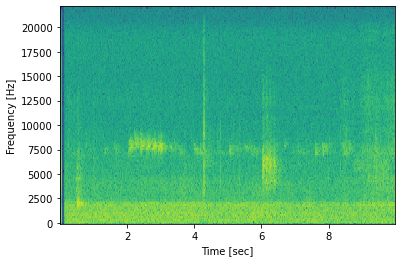

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile

# Read the wav file (stereo)
samplingFrequency, signalData = wavfile.read("/home/parting/Downloads/warblrb10k_public/wav/0a9da934-d6ac-48f1-9739.wav")

# convert to mono if needed
if signalData.ndim == 2:
    signalData = signalData[:,0]

# crop to 10 seconds (44kHz audio)
signalData = signalData[:440000]

frequencies, times, spectrogram = signal.spectrogram(signalData, samplingFrequency)

# draw the image
plt.pcolormesh(times, frequencies, np.log(spectrogram), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [22]:
# some parameters
basedir = "/home/parting/Downloads/warblrb10k_public/spectogram/"
filenames = glob("/home/parting/Downloads/warblrb10k_public/wav/*.wav")

os.makedirs(basedir, exist_ok=True)

#### Convert all samples to spectograms
We will now use this sample process to convert all audio samples to spectograms, to speed it up, lets use the python multiprocessing pool function.

In [ ]:
import os
import sys 
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import math

def make_spectogram(filename):
    # Read the wav file
    samplingFrequency, signalData = wavfile.read(filename)

    # convert to mono if needed
    if signalData.ndim == 2:
        signalData = signalData[:,0]

    # crop to 10 seconds (44kHz audio)
    signalData = signalData[:440000]

    frequencies, times, spectrogram = signal.spectrogram(signalData, samplingFrequency)

    # To make a figure without the frame :
    fig = plt.figure(frameon=False)
    w = 10
    h = 5
    fig.set_size_inches(w,h)

    # To make the content fill the whole figure
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # draw the image
    plt.pcolormesh(times, frequencies, np.log(spectrogram), shading='auto')
    dpi = 50
    savename = os.path.join(basedir, os.path.basename(filename).split(".")[0] + ".jpg")
    fig.savefig(savename, dpi=dpi)
    plt.close(fig)


plt.ioff()
total_processed = 0
num_tasks = len(filenames)

# this will take a few minutes.
p = Pool(4) # adjust number of cores to desired amount or use os.cpu_count()
with p:
    p.map(make_spectogram, filenames)

## Make the pytorch dataset class

### Read the labels
Labels are given in a csv file, each row contains the name of the sample and the classification (bird or notbird), we can read them using pandas and split them up into train/test sets.

In [23]:
# parameters
csv_file = '/home/parting/Downloads/warblrb10k_public/warblrb10k_public_metadata.csv'
device = "cuda:0"
train_test_split = 0.8

df = pd.read_csv(csv_file)
# we'll use a dataframe in a more dict like fashion, using the index as key
df.index = df['itemid']

# split up the dataframe into train and test
train_df = df.iloc[:int(len(df) * train_test_split)]
test_df = df.iloc[int(len(df) * train_test_split):]

print(f"length of trainset: {len(train_df)}, length of test set: {len(test_df)}")

# example
print("example:")
print(f"    spectogram with key: ({'759808e5-f824-401e-9058'}) has class: ({int(df.loc['759808e5-f824-401e-9058'][1])})")

length of trainset: 6400, length of test set: 1600
example:
    spectogram with key: (759808e5-f824-401e-9058) has class: (1)


#### Pytorch dataset class
To load and preprocess all the spectograms we will need a new pytorch dataset class, we will then wrap this dataset class in a dataloader.

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
import pandas as pd
import numpy as np
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

class BirdDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_df = df

        self.root_dir = root_dir
        self.transform = transform
        self.n_classes = 2

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_df.iloc[idx, 0] + ".jpg")
        
        image = io.imread(img_name)
        image = image.astype(np.float32) / 255
        label = self.label_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label, img_name

    
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
        
# make the train and test datasets
birddataset_train = BirdDataset(train_df, basedir, transform=transform)
birddataset_test = BirdDataset(test_df, basedir, transform=transform)

batch_size = 32

# wrap them in dataloaders
train_loader = DataLoader(birddataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(birddataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

# try out the dataset
sample, label, fname = birddataset_train.__getitem__(0)
print(f"sample shape: {sample.shape}, label: {label}, filepath: {fname}")

sample shape: torch.Size([3, 250, 500]), label: 1, filepath: /home/parting/Downloads/warblrb10k_public/spectogram/759808e5-f824-401e-9058.jpg


#### Training and testing the model
We'll use basically the same code that we used to train on the cifar-10 and segmentation datasets. If you're curious, the original paper achieved about 88% accuracy on this dataset, how close can you get ;)?

In [27]:
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval=5, dry_run=False):
    model.train()
    for batch_idx, (data, target, fpaths) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target, fpaths in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 
    

lr = 0.001
gamma = 0.7
epochs = 5

# prepare a pretrained model to train and use.
resnext50 = models.resnext50_32x4d(pretrained=True)
resnext50.fc = nn.Linear(2048, birddataset_train.n_classes)
resnext50 = resnext50.to(device)

# define optimizer, loss function, scheduler
optimizer = optim.Adam(resnext50.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# train, test after each epoch
for epoch in range(1, epochs + 1):
    train(resnext50, device, train_loader, optimizer, criterion, epoch, log_interval=10)
    test(resnext50, device, criterion, test_loader)
    scheduler.step()

Train Epoch: 1 [0/6400 (0%)]	Loss: 0.716621
Train Epoch: 1 [320/6400 (5%)]	Loss: 0.917023
Train Epoch: 1 [640/6400 (10%)]	Loss: 0.488765
Train Epoch: 1 [960/6400 (15%)]	Loss: 0.488223
Train Epoch: 1 [1280/6400 (20%)]	Loss: 0.329241
Train Epoch: 1 [1600/6400 (25%)]	Loss: 0.438231
Train Epoch: 1 [1920/6400 (30%)]	Loss: 0.362171
Train Epoch: 1 [2240/6400 (35%)]	Loss: 0.209669
Train Epoch: 1 [2560/6400 (40%)]	Loss: 0.395219
Train Epoch: 1 [2880/6400 (45%)]	Loss: 0.281148
Train Epoch: 1 [3200/6400 (50%)]	Loss: 0.386766
Train Epoch: 1 [3520/6400 (55%)]	Loss: 0.408836
Train Epoch: 1 [3840/6400 (60%)]	Loss: 0.282657
Train Epoch: 1 [4160/6400 (65%)]	Loss: 0.615043
Train Epoch: 1 [4480/6400 (70%)]	Loss: 0.190952
Train Epoch: 1 [4800/6400 (75%)]	Loss: 0.333555
Train Epoch: 1 [5120/6400 (80%)]	Loss: 0.345319
Train Epoch: 1 [5440/6400 (85%)]	Loss: 0.522153
Train Epoch: 1 [5760/6400 (90%)]	Loss: 0.622854
Train Epoch: 1 [6080/6400 (95%)]	Loss: 0.159630

Test set: Average loss: 0.0252, Accuracy: 1318/

In [28]:
# save model 
# torch.save(resnext50.state_dict(), "bird_class_model.pt")

# load model
# resnext50 = models.resnext50_32x4d()
# resnext50.fc = nn.Linear(2048, birddataset_train.n_classes)
# resnext50.load_state_dict(torch.load("bird_class_model.pt"))
# resnext50.eval()
# resnext50 = resnext50.to(device)
print("done!")

done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/parting/Downloads/warblrb10k_public/spectogram/d22dcc18-e2a2-4561-9de2.jpg /home/parting/Downloads/warblrb10k_public/spectogram/5f2a3cef-f0de-41b9-85c7.jpg


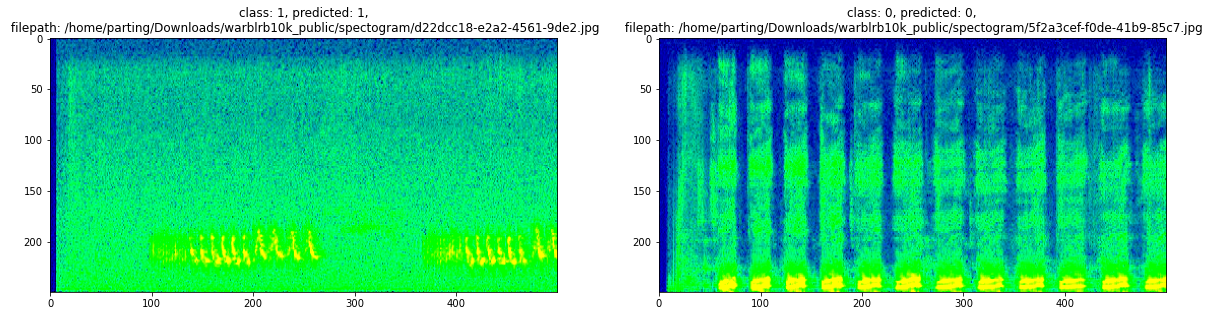

In [31]:
import matplotlib.pyplot as plt

def plot(image_batch, target_batch, fnames):
    image = image_batch[0]
    image2 = image_batch[1]
    target = target_batch[0]
    
    image = image.permute(1, 2, 0)
    image2 = image2.permute(1, 2, 0)
    image_batch = image_batch.to(device)
    output = resnext50(image_batch).cpu()
    image_batch = image_batch.cpu()
    
    pred = torch.argmax(output, dim=1)
    
    # we're plotting normalized images instead of the originals, but it gets the point across I think
    fig, axs = plt.subplots(1, 2, figsize=(20,10))
    axs[0].imshow(image.numpy())
    axs[0].set_title(f"class: {target_batch[0]}, predicted: {pred[0].item()},\n filepath: {fnames[0]}")
    axs[1].imshow(image2.numpy())
    axs[1].set_title(f"class: {target_batch[1]}, predicted: {pred[1].item()},\n filepath: {fnames[1]}")
    print(fnames[0], fnames[1])

for image_batch, target_batch, fnames in test_loader:
    plot(image_batch, target_batch, fnames) 
    break

## Outro
Well... you made it to the end of the exercises! Hope you enjoyed working on them and learned something ;). 
Some suggestions for follow up excersis:
- deep dream the various models that haven't been deepdreamed, you could even try deepdreaming the bird detector.
- try different backbones and see how large models actually have to be for the various problems, does it make a difference which one you use or are they pretty similar?
- try deep dreaming whole layers and try layers early or late into the model, is it also possible to optimize for two targets at very different locations in the model?